# Tabular modelling

Since an embedding is just a look-up into an array, it can handle any kind of discrete categorical data. Embeddings therefore allow us to feed columns that contain categories into a model that expects continuous variables. 

The number of discrete levels of a categorical variable is called its _cardinality_. When you have high-cardinality categorical variables, deep learning approaches can often beat the next-best thing, which is usually gradient-boosted decision trees.

## Bluebook sales competition

The [bluebook datset](https://www.kaggle.com/c/bluebook-for-bulldozers) is a kaggle competition, involving prediction of the auction sale price for a piece of bulldozers. 

In [1]:
from kaggle import api
from fastai.tabular.all import *
from dtreeviz.trees import *
from fastbook import *

In [2]:
path = URLs.path('bluebook')
path

Path('/home/jupyter/.fastai/archive/bluebook')

In [3]:
Path.BASE_PATH = path

In [4]:
if not path.exists():
    path.mkdir()
    api.competition_download_cli('bluebook-for-bulldozers', path=path)
    file_extract(path/'bluebook-for-bulldozers.zip')

In [5]:
path.ls()

(#16) [Path('bluebook-for-bulldozers.zip'),Path('Test.csv'),Path('to.pkl'),Path('Train.zip'),Path('median_benchmark.csv'),Path('Valid.zip'),Path('Machine_Appendix.csv'),Path('Valid.7z'),Path('Data Dictionary.xlsx'),Path('Train.7z')...]

In [6]:
path.ls(file_type='text')

(#7) [Path('Test.csv'),Path('median_benchmark.csv'),Path('Machine_Appendix.csv'),Path('ValidSolution.csv'),Path('Valid.csv'),Path('random_forest_benchmark_test.csv'),Path('TrainAndValid.csv')]

The competition says that the key fields are in `train.csv`, which are:

- SalesID: the unique identifier of the sale
- MachineID: the unique identifier of a machine.  A machine can be sold multiple times
- saleprice: what the machine sold for at auction (only provided in train.csv)
- saledate: the date of the sale


In [7]:
df = pd.read_csv(path/'TrainAndValid.csv', low_memory=False)

(Generally it's good specify `low_memory=False` unless Pandas actually runs out of memory and returns an error because the `low_memory` parameter, which is `True` by default, tells Pandas to only look at a few rows of data at a time to figure out the data type of each column.)

In [8]:
df.columns

Index(['SalesID', 'SalePrice', 'MachineID', 'ModelID', 'datasource',
       'auctioneerID', 'YearMade', 'MachineHoursCurrentMeter', 'UsageBand',
       'saledate', 'fiModelDesc', 'fiBaseModel', 'fiSecondaryDesc',
       'fiModelSeries', 'fiModelDescriptor', 'ProductSize',
       'fiProductClassDesc', 'state', 'ProductGroup', 'ProductGroupDesc',
       'Drive_System', 'Enclosure', 'Forks', 'Pad_Type', 'Ride_Control',
       'Stick', 'Transmission', 'Turbocharged', 'Blade_Extension',
       'Blade_Width', 'Enclosure_Type', 'Engine_Horsepower', 'Hydraulics',
       'Pushblock', 'Ripper', 'Scarifier', 'Tip_Control', 'Tire_Size',
       'Coupler', 'Coupler_System', 'Grouser_Tracks', 'Hydraulics_Flow',
       'Track_Type', 'Undercarriage_Pad_Width', 'Stick_Length', 'Thumb',
       'Pattern_Changer', 'Grouser_Type', 'Backhoe_Mounting', 'Blade_Type',
       'Travel_Controls', 'Differential_Type', 'Steering_Controls'],
      dtype='object')

That's a lot of columns to understand!

It's a good idea to sort out **ordinal** columns, meaning discrete/ordered. For instance, `ProductSize`:

In [9]:
df['ProductSize'].unique()

array([nan, 'Medium', 'Small', 'Large / Medium', 'Mini', 'Large', 'Compact'], dtype=object)

We can tell Pandas about a suitable ordering of levels as follows

In [10]:
sizes = 'Large', 'Large / Medium', 'Medium', 'Small', 'Mini', 'Compact'

In [11]:
df['ProductSize'] = df['ProductSize'].astype('category')
df['ProductSize'].cat.set_categories(sizes, ordered=True, inplace=True)

In [12]:
df['ProductSize']

0            NaN
1         Medium
2            NaN
3          Small
4            NaN
           ...  
412693      Mini
412694      Mini
412695      Mini
412696      Mini
412697      Mini
Name: ProductSize, Length: 412698, dtype: category
Categories (6, object): ['Large' < 'Large / Medium' < 'Medium' < 'Small' < 'Mini' < 'Compact']

`SalePrice` is the dependent variable we are trying to predict.

The evaluation metric for this competition is the RMSLE (root mean squared log error) between the actual and predicted auction prices. So take the log of `SalePrice`:

In [13]:
dep_var = 'SalePrice'

In [14]:
df[dep_var] = np.log(df[dep_var])

### Handling of dates

If we're going to take advantage of dates, we can use fastai's `add_datepart` which generates additional columns using the date. This is an example of **feature engineering**.

In [15]:
df = add_datepart(df, 'saledate')

In [16]:
' '.join(o for o in df.columns if o.startswith('sale'))

'saleYear saleMonth saleWeek saleDay saleDayofweek saleDayofyear saleIs_month_end saleIs_month_start saleIs_quarter_end saleIs_quarter_start saleIs_year_end saleIs_year_start saleElapsed'

Let's do the same for the test set while we're at it

In [17]:
df_test = pd.read_csv(path/'Test.csv', low_memory=False)
df_test = add_datepart(df_test, 'saledate')

### Using `TabularPandas` and `TabularProc` in fastai

Out of the box, sklearn can't handle strings or missing data. `TabularPandas` wraps a Pandas DataFrame and provides a few convenience methods.

To populate a `TabularPandas` we'll use two `TabularProc`s: `Categorify` and `FillMissing`.

- `Categorify`: Replaces a column witha numeric categorical column
- `FillMissing`: Replaces missing values with the median of the column, and creates a new Boolean column that is `True` for any row where the value was missing.

A `TabularProc` is like a regular `Transform` except it does the transformations in-place, and when the data are first passed in (rather than lazily as data is accessed), to save memory and time.

In [18]:
procs = [Categorify, FillMissing]

`TabularPandas` will also partition into train/valid.

The test set in this competition is 2 weeks after the final training date. We should do something similar for our train/valid split.

In [19]:
np.sort(df.saleYear.unique())

array([1989, 1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012])

In [20]:
df[df['saleYear']>=2011][['saleYear', 'saleMonth']].drop_duplicates().sort_values(by=['saleYear', 'saleMonth'])

,saleYear,saleMonth
749,2011,1
52,2011,2
697,2011,3
66,2011,4
3,2011,5
35,2011,6
197,2011,7
287,2011,8
9996,2011,9
22915,2011,10


In [21]:
cond = (df.saleYear<2011) | (df.saleMonth<10)

In [22]:
train_idx = np.where(cond)[0]
valid_idx = np.where(~cond)[0]

In [23]:
splits = (list(train_idx), list(valid_idx))

`TabularPandas` needs to be told which columns are continuous and which are categorical. We can handle that by using the helper function `cont_cat_split`:

In [24]:
cont, cat = cont_cat_split(df, 1, dep_var=dep_var)

In [25]:
L(cont)

(#12) ['SalesID','MachineID','ModelID','datasource','auctioneerID','YearMade','MachineHoursCurrentMeter','saleYear','saleMonth','saleDay'...]

In [26]:
L(cat)

(#52) ['UsageBand','fiModelDesc','fiBaseModel','fiSecondaryDesc','fiModelSeries','fiModelDescriptor','ProductSize','fiProductClassDesc','state','ProductGroup'...]

In [27]:
to = TabularPandas(df, procs, cat, cont, y_names=dep_var, splits=splits)

A `TabularPandas` behaves much like a fastai `Datasets` object, including `train` and `valid` attributes

In [28]:
len(to.train), len(to.valid)

(404710, 7988)

The data is still displayed as strings for categories

In [29]:
to.show(3)

,UsageBand,fiModelDesc,fiBaseModel,fiSecondaryDesc,fiModelSeries,fiModelDescriptor,ProductSize,fiProductClassDesc,state,ProductGroup,ProductGroupDesc,Drive_System,Enclosure,Forks,Pad_Type,Ride_Control,Stick,Transmission,Turbocharged,Blade_Extension,Blade_Width,Enclosure_Type,Engine_Horsepower,Hydraulics,Pushblock,Ripper,Scarifier,Tip_Control,Tire_Size,Coupler,Coupler_System,Grouser_Tracks,Hydraulics_Flow,Track_Type,Undercarriage_Pad_Width,Stick_Length,Thumb,Pattern_Changer,Grouser_Type,Backhoe_Mounting,Blade_Type,Travel_Controls,Differential_Type,Steering_Controls,saleWeek,saleIs_month_end,saleIs_month_start,saleIs_quarter_end,saleIs_quarter_start,saleIs_year_end,saleIs_year_start,saleElapsed,auctioneerID_na,MachineHoursCurrentMeter_na,SalesID,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,saleYear,saleMonth,saleDay,saleDayofweek,saleDayofyear,SalePrice
0,Low,521D,521,D,#na#,#na#,#na#,Wheel Loader - 110.0 to 120.0 Horsepower,Alabama,WL,Wheel Loader,#na#,EROPS w AC,None or Unspecified,#na#,None or Unspecified,#na#,#na#,#na#,#na#,#na#,#na#,#na#,2 Valve,#na#,#na#,#na#,#na#,None or Unspecified,None or Unspecified,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,Standard,Conventional,46,False,False,False,False,False,False,1163635200,False,False,1139246,999089,3157,121,3.0,2004,68.0,2006,11,16,3,320,11.097410
1,Low,950FII,950,F,II,#na#,Medium,Wheel Loader - 150.0 to 175.0 Horsepower,North Carolina,WL,Wheel Loader,#na#,EROPS w AC,None or Unspecified,#na#,None or Unspecified,#na#,#na#,#na#,#na#,#na#,#na#,#na#,2 Valve,#na#,#na#,#na#,#na#,23.5,None or Unspecified,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,Standard,Conventional,13,False,False,False,False,False,False,1080259200,False,False,1139248,117657,77,121,3.0,1996,4640.0,2004,3,26,4,86,10.950807
2,High,226,226,#na#,#na#,#na#,#na#,Skid Steer Loader - 1351.0 to 1601.0 Lb Operating Capacity,New York,SSL,Skid Steer Loaders,#na#,OROPS,None or Unspecified,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,Auxiliary,#na#,#na#,#na#,#na#,#na#,None or Unspecified,None or Unspecified,None or Unspecified,Standard,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,9,False,False,False,False,False,False,1077753600,False,False,1139249,434808,7009,121,3.0,2001,2838.0,2004,2,26,3,57,9.210340


But the underlying items are all numeric

In [30]:
to.items.head(3)

,SalesID,SalePrice,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,fiModelDesc,fiBaseModel,fiSecondaryDesc,fiModelSeries,fiModelDescriptor,ProductSize,fiProductClassDesc,state,ProductGroup,ProductGroupDesc,Drive_System,Enclosure,Forks,Pad_Type,Ride_Control,Stick,Transmission,Turbocharged,Blade_Extension,Blade_Width,Enclosure_Type,Engine_Horsepower,Hydraulics,Pushblock,Ripper,Scarifier,Tip_Control,Tire_Size,Coupler,Coupler_System,Grouser_Tracks,Hydraulics_Flow,Track_Type,Undercarriage_Pad_Width,Stick_Length,Thumb,Pattern_Changer,Grouser_Type,Backhoe_Mounting,Blade_Type,Travel_Controls,Differential_Type,Steering_Controls,saleYear,saleMonth,saleWeek,saleDay,saleDayofweek,saleDayofyear,saleIs_month_end,saleIs_month_start,saleIs_quarter_end,saleIs_quarter_start,saleIs_year_end,saleIs_year_start,saleElapsed,auctioneerID_na,MachineHoursCurrentMeter_na
0,1139246,11.097410,999089,3157,121,3.0,2004,68.0,2,963,298,43,0,0,0,59,1,6,6,0,3,1,0,2,0,0,0,0,0,0,0,1,0,0,0,0,17,3,0,0,0,0,0,0,0,0,0,0,0,0,4,2,2006,11,46,16,3,320,1,1,1,1,1,1,2647,1,1
1,1139248,10.950807,117657,77,121,3.0,1996,4640.0,2,1745,529,57,98,0,3,62,33,6,6,0,3,1,0,2,0,0,0,0,0,0,0,1,0,0,0,0,12,3,0,0,0,0,0,0,0,0,0,0,0,0,4,2,2004,3,13,26,4,86,1,1,1,1,1,1,2148,1,1
2,1139249,9.210340,434808,7009,121,3.0,2001,2838.0,1,336,111,0,0,0,0,39,32,3,3,0,6,1,0,0,0,0,0,0,0,0,0,4,0,0,0,0,0,3,1,1,3,0,0,0,0,0,0,0,0,0,0,0,2004,2,9,26,3,57,1,1,1,1,1,1,2131,1,1


The `.classes` attribute is essentially a `vocab` for tabular data

In [31]:
to.classes['ProductSize']

(#7) ['#na#','Large','Large / Medium','Medium','Small','Mini','Compact']

In [32]:
(path/'to.pkl').save(to)

## Decision trees

We'll start with decision trees for our modelling.

In [33]:
from sklearn.tree import DecisionTreeRegressor

In [34]:
to = (path/'to.pkl').load()

In [35]:
xs, y = to.train.xs, to.train.y
valid_xs, valid_y = to.valid.xs, to.valid.y

Now that the data are all numeric, and there are no missing values, we can create a decision tree

In [36]:
m = DecisionTreeRegressor(max_leaf_nodes=4)
m.fit(xs, y);

If I could get `graphviz` to work, I would draw the tree here.

In [37]:
#draw_tree(m, xs, size=7, leaves_parallel=True, precision=2)

To get something like this

<img src="./figures/tree.png" style="width:500px"> 

We can show the same information using dtreeviz

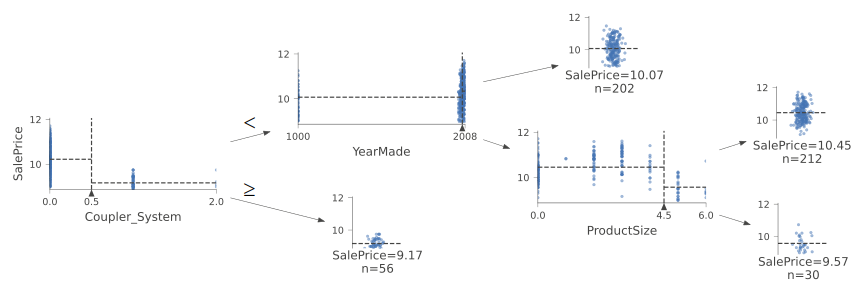

In [38]:
samp_idx = np.random.permutation(len(y))[:500]
dtreeviz(m, xs.iloc[samp_idx], y.iloc[samp_idx], xs.columns, dep_var,
        fontname='DejaVu Sans', scale=1.6, label_fontsize=10,
        orientation='LR')

`YearMade` seems to have a missing value code of 1000

In [39]:
xs.loc[xs['YearMade']<1900, 'YearMade'] = 1950
valid_xs.loc[valid_xs['YearMade']<1900, 'YearMade'] = 1950

Note that the above won't change the result of the model, since decision trees only care about ranks in the independent variables

In [40]:
m = DecisionTreeRegressor(max_leaf_nodes=4).fit(xs, y)

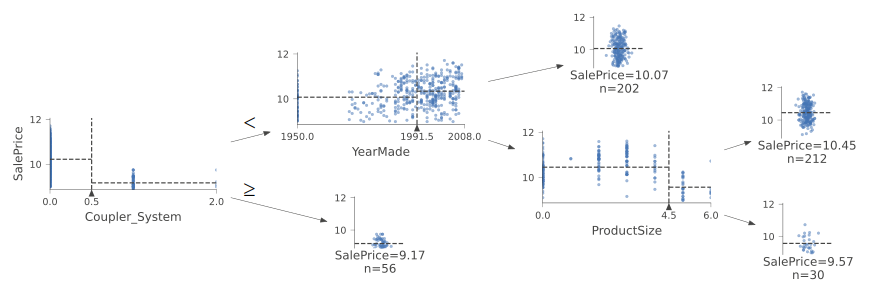

In [41]:
dtreeviz(m, xs.iloc[samp_idx], y.iloc[samp_idx], xs.columns, dep_var,
        fontname='DejaVu Sans', scale=1.6, label_fontsize=10,
        orientation='LR')

Let's build a deeper tree

In [42]:
m = DecisionTreeRegressor()
m.fit(xs, y);

In [43]:
def r_mse(pred, y): return round(math.sqrt(((pred-y)**2).mean()), 6)
def m_rmse(m, xs, y): return r_mse(m.predict(xs), y)

In [44]:
m_rmse(m, xs, y)

0.0

So the training error is 0

In [45]:
m_rmse(m, valid_xs, valid_y)

0.330103

But the validation error isn't -- so we're probably overfitting quite badly

In [46]:
m.get_n_leaves(), len(xs)

(324550, 404710)

so we have almost 1 leaf per datapoint -- which pretty much the most overfit you can have in a model.

In [47]:
m = DecisionTreeRegressor(min_samples_leaf=25)
m.fit(to.train.xs, to.train.y)
m_rmse(m, xs, y), m_rmse(m, valid_xs, valid_y)

(0.248562, 0.323392)

In [48]:
m.get_n_leaves()

12397

Which is a bit more reasonable.

## Random Forests

Random forests, proposed by Leo Breiman in ["Bagging Predictors"](https://www.stat.berkeley.edu/~breiman/bagging.pdf), have the following steps:

1. Randomly choose a subset of the rows of your data. (Also choose a subset of the columns, this is called the "random subspace" method).
1. Train a model using this subset.
1. Save that model, and then return to step 1 a few times.
1. This will give you a number of trained models. To make a prediction, predict using all of the models, and then take the average of each of those model's predictions.

This is a procedure called "bagging" or "bootstrap aggregating". The errors between these models are uncorrelated because they each use random subsets of the data (and features), hence taking an aggregate of these weak learners can give more accurate results.


In [49]:
from sklearn.ensemble import RandomForestRegressor

In [50]:
n_estimators=40  # number of trees to train
max_samples=200_000  # number of rows to use for each model (about half the data)
max_features=0.5  # number of features to use for each model
min_samples_leaf=5  # stopping criterion for each model

def rf(xs, y):
    return RandomForestRegressor(n_jobs=-1, n_estimators=n_estimators,
            max_samples=max_samples, max_features=max_features,
            min_samples_leaf=min_samples_leaf, oob_score=True).fit(xs, y)


In [51]:
m = rf(xs, y)

In [52]:
m_rmse(m, xs, y), m_rmse(m, valid_xs, valid_y)

(0.170848, 0.234122)

**This is substantially better than a single, deep, tree**

The nice thing about random forests is how robust it is to overfitting -- you can add lots of estimators, and because each learner is so weak, you won't really overfit.

To get at the underlying trees, we can use `m.estimators_`. We can get the predictions from each individual tree:

In [53]:
preds = np.stack([t.predict(valid_xs) for t in m.estimators_])

In [54]:
r_mse(preds.mean(0), valid_y)

0.234122

We can see how the validation error reduces with the number of learners. 

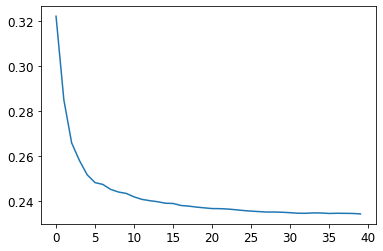

In [55]:
plt.plot([r_mse(preds[:i+1].mean(0), valid_y) for i in range(40)]);

The performance really flattens after around 30 trees

The performance on our validation set is worse than on our training set. But is that because we're overfitting, or because the validation set covers a different time period, or a bit of both?

### Out-of-Bag error

Out-of-bag error (OOB) is the mean prediction error on each training sample $x_i$, using only the trees that did not have $x_i$ in their bootstrap sample.

This gives us a measure of out-of-sample prediction error, without making a separate training partition. We can access OOB predictions with the `oob_prediction_` attribute

In [56]:
r_mse(m.oob_prediction_, y)

0.210609

Our OOB error is lower than our validation set error, suggesting that an external source of error is affecting our validation set in addition to usual generalization error.

We'll come back to this later.

## Model Interpretation

For tabular data, model interpretation is particularly important. For a given model, we'll likely be interested in:

- How confident are we in our preditions for any given observation? (Tree variance)
- What were the most important factors in a prediction for any given row? (Tree interpreter)
- Which features are the strongest predictors, and which can we ignore? (Feature importance)
- Which features are effectively redundant with each other, for the purposes of prediction? (Dendrogram)
- How do predictions of the dependent variable vary, as we vary important columns in isolation? (Partial dependence)

Random forests are particularly well suited to answering these questions...

### Tree variance for prediction confidence

For every row in our validation dataset, let's compute the standard deviation of the predictions over all trees

In [57]:
preds = np.stack([t.predict(valid_xs) for t in m.estimators_])

In [58]:
preds.shape

(40, 7988)

In [59]:
preds_cv = preds.std(0)/preds.mean(0)

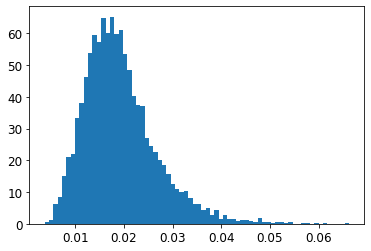

In [60]:
plt.hist(preds_cv, bins='auto', density=True);

The confidence varies quite widely, but the absolute magnitude of the coefficient of variation is pretty low -- about 1%. So, in absolute terms, the model seems pretty certain I'd say.

### Feature importance

It's often important to be able to interpret which features are the most important for any given prediction. sklearn has a `feature_importances_` attribute based on Gini Importance

In [61]:
def rf_feat_importance(m, df):
    return pd.DataFrame({'cols':df.columns, 'imp':m.feature_importances_}
                       ).sort_values('imp', ascending=False)

In [62]:
fi = rf_feat_importance(m, xs)
fi[:10]

,cols,imp
59,YearMade,0.176688
30,Coupler_System,0.125501
6,ProductSize,0.122304
7,fiProductClassDesc,0.066591
56,ModelID,0.051802
51,saleElapsed,0.050033
3,fiSecondaryDesc,0.047952
31,Grouser_Tracks,0.042753
1,fiModelDesc,0.031504
12,Enclosure,0.029119


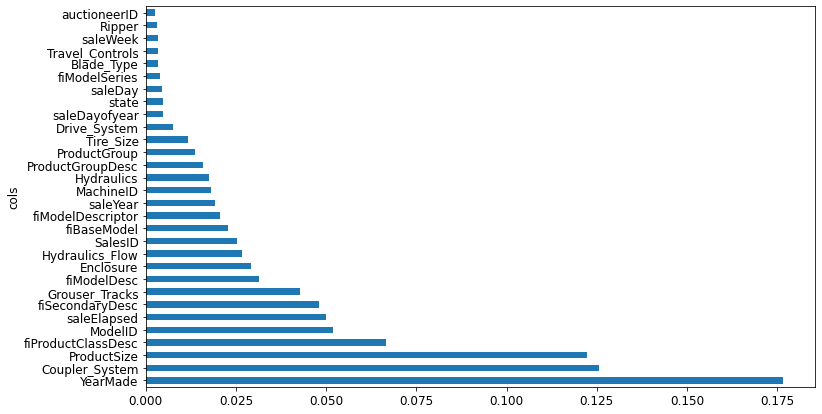

In [63]:
def plot_fi(fi):
    return fi.plot('cols', 'imp', 'barh', figsize=(12,7), legend=False)

plot_fi(fi[:30]);

The Gini Importance consists of a loop through each tree. Then recursively explore each branch, and see which feature was used for the split, and how much the results improves as a result of that split. The improvement, weighted by the number of rows in that group, is added to the importance score for that feature. This is summed over all branches of all trees, and then normalized to 1 over all features.

### Removing low-importance features

In [64]:
to_keep = fi[fi.imp>0.005].cols
len(to_keep)

21

In [65]:
xs_imp = xs[to_keep]
valid_xs_imp = valid_xs[to_keep]

In [66]:
len(xs.columns), len(xs_imp.columns)

(66, 21)

In [67]:
m = rf(xs_imp, y)

In [68]:
m_rmse(m, xs_imp, y), m_rmse(m, valid_xs_imp, valid_y)

(0.181544, 0.231401)

About the same performance with far fewer features, making our feature importance plot easier to interpret

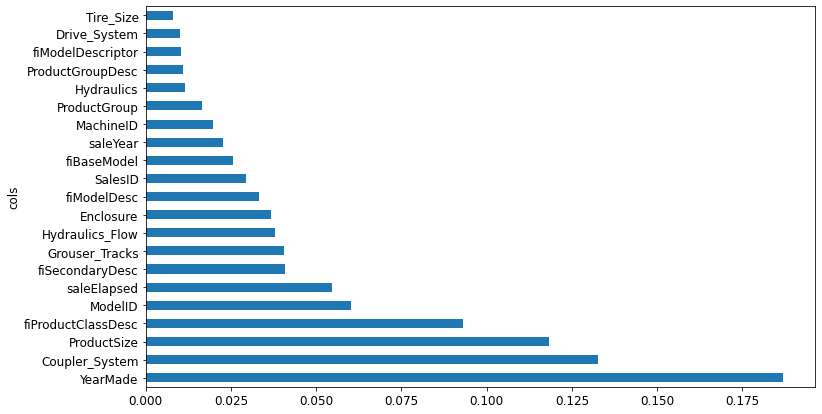

In [69]:
plot_fi(rf_feat_importance(m, xs_imp));

One further difficulty is the existence of **correlated** features?

### Removing redundant features

Generate a dendrogram from the raw data using rank correlation

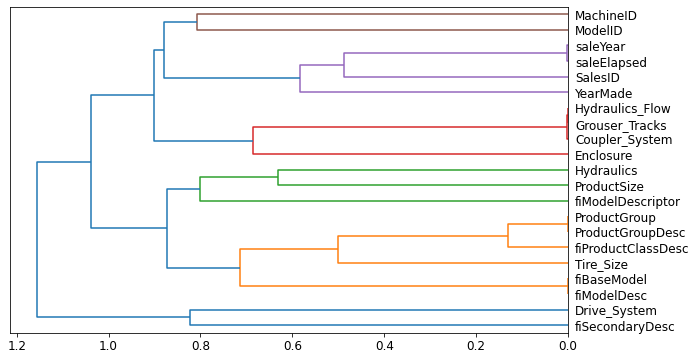

In [70]:
cluster_columns(xs_imp)

`saleYear` and `saleElapsed` are very similar from the dendrogram.

Let's do a fast version of OOB, and remove each variable one at a time to see which affect the OOB least

In [71]:
def get_oob(df):
    m = RandomForestRegressor(n_estimators=40, min_samples_leaf=15,
        max_samples=50000, max_features=0.5, n_jobs=-1, oob_score=True)
    m.fit(df, y)
    return m.oob_score_

Baseline:

In [72]:
get_oob(xs_imp)

0.877206273717813

In [73]:
{c:get_oob(xs_imp.drop(c, axis=1)) for c in (
    'saleYear', 'saleElapsed', 'ProductGroupDesc','ProductGroup',
    'fiModelDesc', 'fiBaseModel',
    'Hydraulics_Flow','Grouser_Tracks', 'Coupler_System')}

{'saleYear': 0.8761723908037912,
 'saleElapsed': 0.8722254636968529,
 'ProductGroupDesc': 0.8766732622373703,
 'ProductGroup': 0.8782365682176777,
 'fiModelDesc': 0.8759246561934972,
 'fiBaseModel': 0.8764292790933444,
 'Hydraulics_Flow': 0.8777217358428255,
 'Grouser_Tracks': 0.8776169815092842,
 'Coupler_System': 0.877680588835708}

Let's drop one variable from the pair of 5 variables which were highly correlated

In [74]:
to_drop = ['saleYear', 'ProductGroupDesc', 'fiBaseModel', 'Grouser_Tracks']
get_oob(xs_imp.drop(to_drop, axis=1))

0.8750570717508293

So OOB barely changed, which is good. Let's drop them and retrain.

In [75]:
xs_final = xs_imp.drop(to_drop, axis=1)
valid_xs_final = valid_xs_imp.drop(to_drop, axis=1)

In [76]:
m = rf(xs_final, y)
m_rmse(m, xs_final, y), m_rmse(m, valid_xs_final, valid_y)

(0.183518, 0.232507)

By focusing on the most important variables, and removing some redundant ones, we've greatly simplified our model.

### Partial dependence

For the most important columns, what's the relationship between the feature of interest and the dependent variable?

Let's consider `ProductSize` and `YearMade`. First, let's just see how they're distributed

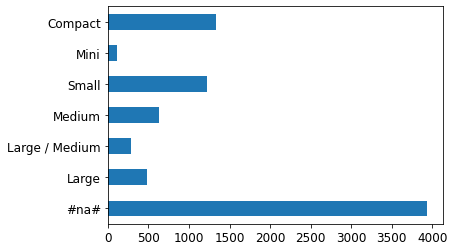

In [77]:
p = valid_xs_final['ProductSize'].value_counts(sort=False).plot.barh()
c = to.classes['ProductSize']
plt.yticks(range(len(c)), c);

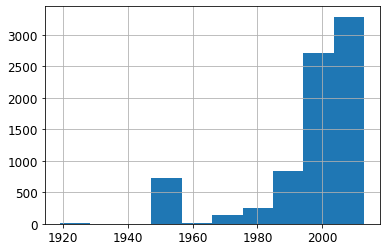

In [78]:
ax = valid_xs_final['YearMade'].hist()

where 1950 is used for missing values

Now we can look at _partial dependence_ plots. These try to answer the question: if only feature $x$ varied, how would it impact the dependent variable?

In [79]:
from sklearn.inspection import plot_partial_dependence

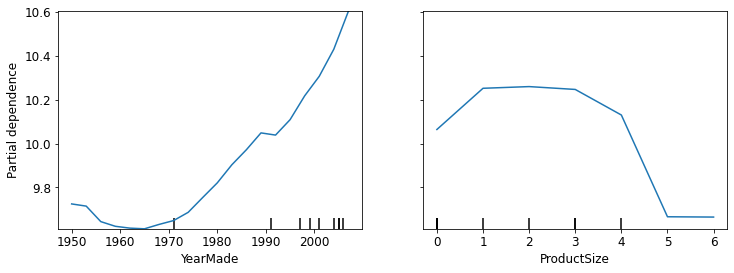

In [80]:
fig,ax = plt.subplots(figsize=(12, 4))
plot_partial_dependence(m, valid_xs_final, ['YearMade','ProductSize'],
                        grid_resolution=20, ax=ax);

For `YearMade`, in the region where there's a lot of data (1970 onwards), as year increases, **all else equal** the sale price increases roughly exponentially (which makes some sense due to inflation).

The method here is to perform the following. Let $X_s$ be the set of target features and $X_c$ its complement.

The partial dependence of the response $f$ at point $x_s$ is defined as

$$pd_{X_s}(x_s) = \mathbb{E}_{X_c}[f(x_s, X_C)] = \int f(x_s, x_C) p(x_C) dx_C$$

where $f(x_s, x_C)$ us the response function for a given sample whose values are defined by $x_s$ for features in $X_s$ and by $x_c$ for features in $X_C$.

In other words, taking the mean of the dependent variable, for different levels of the variable of interest, weighted by the probability of observing the complement of those variables. See [here](https://scikit-learn.org/stable/modules/partial_dependence.html#partial-dependence).

The observation that `ProductSize = na` is highly predictive, suggests that this feature _is not missing at random_. That's a bit of a worry, and we might want to investigate that further... It can be an example of **data leakage** (information which should not legitimately be available to mine from).

### Tree interpreter

In [81]:
import warnings
warnings.simplefilter('ignore', FutureWarning)

from treeinterpreter import treeinterpreter
from waterfall_chart import plot as waterfall

`treeinterpreter` works in a similar way to `m.feature_importances_`, except it works on a single observation, allowing us to attempt to answer _why_ a given prediction was made.

We take our observation and put it through the first decision tree of the random forest. For each split, we see what the increase or decrease in the prediction is, compared to the parent node of the tree. We sum this quantity up for all split features, across all trees in the random forest, and then normalize.

So, we pass in a single row:

In [82]:
row = valid_xs_final.iloc[:5]

and give it to the tree interpreter

In [87]:
prediction, bias, contributions = treeinterpreter.predict(m, row.values)

then, from the model, generate the following quantities:

- `prediction`: simply the prediction from the random forest
- `bias`: prediction based on taking the mean of the dependent variable
- `contributions`: total change in prediction due to each independent variable

Thus, `sum(contributions) + bias = prediction`

In [88]:
contributions.shape

(5, 17)

In [92]:
prediction[0], bias[0], contributions[0].sum()

(array([9.96287001]), 10.104746057831765, -0.14187604900474668)

One way to visualize the contributions is with a _waterfall plot_

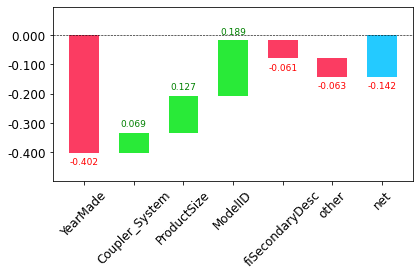

In [94]:
waterfall(valid_xs_final.columns, contributions[0], 
          threshold=0.08, # for "other"
          rotation_value=45, formatting='{:,.3f}');

Here, 0 is the `bias`, which is the average prediction over the whole dataset. Then each feature corresponds to the impact on the prediction.

## Extrapolation and neural networks

Random forests don't perform so well when you try to make predictions outside of the domain of the training set (i.e. extrapolation) because they simply assign constant values to each split of the features. This means that for a task as simple as linear regression, random forests can generalize badly for the task of extrapolation.

In [95]:
np.random.seed(42)

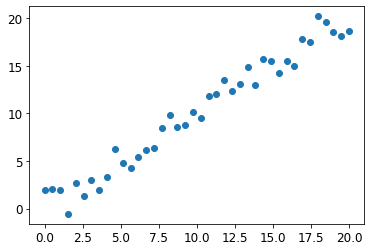

In [96]:
x_lin = torch.linspace(0,20,steps=40)
y_lin = x_lin + torch.randn_like(x_lin)
plt.scatter(x_lin, y_lin);

In [102]:
xs_lin = x_lin.unsqueeze(1)
x_lin.shape, xs_lin.shape

(torch.Size([40]), torch.Size([40, 1]))

In [105]:
x_lin[:, None].shape  # (a neater way)

torch.Size([40, 1])

In [106]:
m_lin = RandomForestRegressor().fit(xs_lin[:30], y_lin[:30])

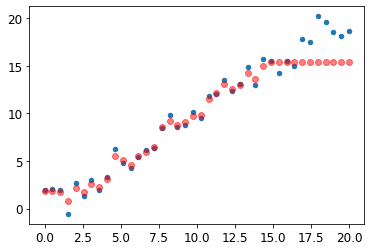

In [108]:
plt.scatter(x_lin, y_lin, 20)
plt.scatter(x_lin, m_lin.predict(xs_lin), color='red', alpha=0.5);

This is a more general issue than just time variables -- any time we want to make predictions in areas of space which do not have support under the training set will have this problem.

### Finding out of domain data

How can we find out if our test set is distributed in the same way as our training set? There's an easy way to do this using a random forest!

To do this, we use the random forest to predict whether an observation is in the validation set or the training set by creating a new feature `is_valid`. If the validation set and the training set are identically distributed, then there should be no way to predict `is_valid`. 

In [109]:
df_dom = pd.concat([xs_final, valid_xs_final])
is_valid = np.array([0]*len(xs_final) + [1]*len(valid_xs_final))

m = rf(df_dom, is_valid)
rf_feat_importance(m, df_dom)[:6]

,cols,imp
5,saleElapsed,0.868257
10,SalesID,0.097158
12,MachineID,0.027214
0,YearMade,0.002837
4,ModelID,0.001094
8,Enclosure,0.000672


We see that the most important feature in predicting `is_valid` is `saleElapsed`, i.e. the date -- which is good because that's how the validation set was defined.

`SalesID` and `MachineID` also seem to have some predictive power for `is_valid`, suggesting that they may have some time dependence.

What happens to our predictions if we take each of those 3 columns and remove them, and see how the model performs

In [110]:
m = rf(xs_final, y)
print('orig', m_rmse(m, valid_xs_final, valid_y))

for c in ('saleElapsed', 'SalesID', 'MachineID'):
    m = rf(xs_final.drop(c, axis=1), y)
    print(c, m_rmse(m, valid_xs_final.drop(c, axis=1), valid_y))

orig 0.231595
saleElapsed 0.236062
SalesID 0.230427
MachineID 0.231683


So we should be able to remove at least `SalesID` and `MachineID`

In [111]:
time_vars = ['SalesID','MachineID']
xs_final_time = xs_final.drop(time_vars, axis=1)
valid_xs_time = valid_xs_final.drop(time_vars, axis=1)

m = rf(xs_final_time, y)
m_rmse(m, valid_xs_time, valid_y)

0.228977

Removing these two variables has slightly improved the model accuracy. It should also make the model more resilient over time. The `is_valid` trick is generally useful for discovering _domain shift_ issues.

It can also be helpful to just avoid old data, which can have relationships which are no longer valid

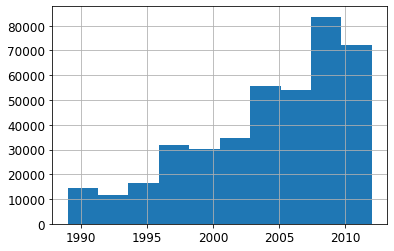

In [112]:
xs['saleYear'].hist();

In [113]:
filt = xs['saleYear']>2004
xs_filt = xs_final_time[filt]
y_filt = y[filt]

In [114]:
m = rf(xs_filt, y_filt)
m_rmse(m, xs_filt, y_filt), m_rmse(m, valid_xs_time, valid_y)

(0.177557, 0.228338)

Slight improvement, showing that it's not always best to train on the whole dataset

### Using a neural network

The extrapolation issue with random forests will not happen with a neural net. The underlying layers of a neural net are combinations of linear functions and non-linear activations. So out-of-domain prediction has some hope of working with a neural net.

Data cleaning, as before:

In [267]:
df_nn = pd.read_csv(path/'TrainAndValid.csv', low_memory=False)
df_nn['ProductSize'] = df_nn['ProductSize'].astype('category')
df_nn['ProductSize'].cat.set_categories(sizes, ordered=True, inplace=True)
df_nn[dep_var] = np.log(df_nn[dep_var])
df_nn = add_datepart(df_nn, 'saledate')

And lets trim the unwanted columns, as we discovered from the random forest work

In [268]:
df_nn_final = df_nn[list(xs_final_time.columns) + [dep_var]]

For categorical columns, we should use embeddings. To determine which variables are categorical, we used `cont_cat_split`, which compares the cardinality of a feature with the hyper-parameter `max_card`: larger cardinality means the variable is treated as continuous.

Embedding sizes larger than 10,000 should generally only be used after testing whether there are better ways to group the variable. So let's use 9,000 as `max_card`.

In [269]:
cont_nn, cat_nn = cont_cat_split(df_nn_final, max_card = 9_000, dep_var = dep_var)

However, one variable we absolutely _do not_ want to treat as categorical is `saleElapsed` because it is essentially a measure of time, so we will need it to extrapolate outside of the domain of our training data

In [270]:
cont_nn.append('saleElapsed')
cat_nn.remove('saleElapsed')

Let's look at the cardinality of each of the categorical variables selected by `fastai`:

In [271]:
df_nn_final[cat_nn].nunique()

YearMade                73
Coupler_System           2
ProductSize              6
fiProductClassDesc      74
ModelID               5281
fiSecondaryDesc        177
fiModelDesc           5059
Enclosure                6
Hydraulics_Flow          3
fiModelDescriptor      140
Hydraulics              12
ProductGroup             6
Tire_Size               17
Drive_System             4
dtype: int64

It's a little worrisome to have independent variables with loads of categories, because they will have so many parameters. Perhaps `ModelID` and `fiModelDesc` are describing the same thing, so we can get rid of one of them?

We can decide this using a random forest.

In [272]:
xs_filt2 = xs_filt.drop('fiModelDescriptor', axis=1)
valid_xs_time2 = valid_xs_time.drop('fiModelDescriptor', axis=1)
m2 = rf(xs_filt2, y_filt)
m_rmse(m2, xs_filt2, y_filt),  m_rmse(m2, valid_xs_time2, valid_y)

(0.176911, 0.230768)

Previous result:

In [273]:
m_rmse(m, xs_filt, y_filt), m_rmse(m, valid_xs_time, valid_y)

(0.177557, 0.228338)

Pretty minimal impact -- in fact a tiny bit better, so we'll drop `fiModelDescriptor`.

In [274]:
cat_nn.remove('fiModelDescriptor')

Now we create our `TabularPandas` object as before, with one important addition: `Normalize` (which is simply z-scoring each feature to help model learning by keeping features on the same scale). Random forests didn't need a `Normalize` because it only cares about ranks.

In [276]:
df_nn_final = df_nn_final.astype({cont_nn[0]: 'int32'})  # cast the continuous variable as numeric, or it'll confuse fastai

In [278]:
procs_nn = [Categorify, FillMissing, Normalize]
to_nn = TabularPandas(df_nn_final, procs_nn, cat_nn, cont_nn, 
                      splits=splits, y_names=dep_var)

In [279]:
dls = to_nn.dataloaders(1024)  # can use large batches for tabular data

It's a good idea to set the ranges of the dependent variable

In [282]:
y = to_nn.train.y
y.min(),y.max()

(8.465899467468262, 11.863582611083984)

We can now use the `tabular_learner` factory method

In [283]:
learn = tabular_learner(dls, y_range=(8,12), layers=[500, 250], n_out=1, loss_func=F.mse_loss)

In [284]:
learn.summary()

TabularModel (Input shape: ['1024 x 13', '1024 x 1'])
Layer (type)         Output Shape         Param #    Trainable 
Embedding            1024 x 18            1,314      True      
________________________________________________________________
Embedding            1024 x 3             9          True      
________________________________________________________________
Embedding            1024 x 5             35         True      
________________________________________________________________
Embedding            1024 x 18            1,350      True      
________________________________________________________________
Embedding            1024 x 194           1,016,948  True      
________________________________________________________________
Embedding            1024 x 29            5,162      True      
________________________________________________________________
Embedding            1024 x 190           961,400    True      
____________________________________________

Categorical independent variables are passed through an embedding, and concatenated together, along with continuous variables. The vector is then passed through a fairly standard neural net with a desired number of layers/activations.

SuggestedLRs(lr_min=0.002754228748381138, lr_steep=0.0002754228771664202)

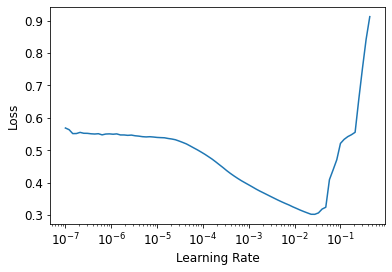

In [286]:
learn.lr_find()

In [287]:
learn.fit_one_cycle(5, 5e-3)

epoch,train_loss,valid_loss,time
0,0.069162,0.063149,00:06
1,0.056614,0.058835,00:06
2,0.049925,0.056171,00:06
3,0.043974,0.052095,00:06
4,0.040697,0.051901,00:07


In [288]:
preds, targs = learn.get_preds()
r_mse(preds, targs)

0.227818

That's pretty good! Comparable to a random forest.

In [290]:
learn.save('nn');

## Ensembling

We can ensemble together the neural net and the random forest

In [294]:
rf_preds = m.predict(valid_xs_time)
ens_preds = (to_np(preds.squeeze()) + rf_preds)/2

In [295]:
r_mse(ens_preds, valid_y)

0.222863

So a slight improvement there too. This is actually better than anything on the Kaggle leaderboard, with the top score being 0.22909. It's not directly comparable because we don't have access to the test set, but this is encouraging!

## Combining embeddings with other methods